In [ ]:
from google.colab import drive

drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
savepath = '/content/gdrive/My Drive/fairMDAV/Datasets/'

### Fair MDAV

In [ ]:
import numpy as np
import pandas as pd

from multiprocessing import Pool
from sklearn.metrics.pairwise import euclidean_distances
from sklearn.model_selection import train_test_split
from tqdm.notebook import *

In [ ]:
def ttSplit(df, ts=0.2, rs=42, size=1000):
    df = (df
          .head(size)
          .reset_index()
          .rename(columns={'index': 'id', pa: 'pa'}))
    
    dtrain, dtest = train_test_split(df, test_size=ts, random_state=rs)
    dtrain = (dtrain
          .copy()
          .drop('id', axis=1)
          .reset_index(drop=True)
          .reset_index()
          .rename(columns={'index':'id'}))
    dtrain.to_csv(savepath + name + '_train.csv', index=False)
    dtest.to_csv(savepath + name + '_test.csv', index=False)
    return dtrain

In [ ]:
def d2df(row, feats, auxdf):
        d = euclidean_distances(auxdf[feats], row).tolist()
        l = [item for sublist in d for item in sublist]
        return l

In [ ]:
def makeFairlets(df, feats, n_fairlets, k=0):
    df = df.copy()
    fairlets = {}
    n_pa = df.pa.nunique()
    
    while (len(df.index) > 0):
        center = pd.DataFrame([round(df[feats].mean(), 0)])
        df['centerDist'] = d2df(center, feats, df)
        far = df.nlargest(1, 'centerDist')
        far_id = far.id.iloc[0]
        df['farDist'] = d2df(far[feats], feats, df)
       
        if k != 0:
            indices = df.nsmallest(k, 'farDist')['id'].tolist() 
        else:
            pas = [df[df.pa == i] for i in range(n_pa)]
            near = [pas[i]
                    .nsmallest(n_fairlets[i], 'farDist')['id']
                    .tolist()
                    for i in range(n_pa)]
            indices = [i for pa in near for i in pa]
        
        fairlets[far_id] = indices
        df.drop(indices, inplace=True)
        
    return fairlets

In [ ]:
def makefCenters(df, fairlets, feats):
    nd = {f: [round(df[f]
              .iloc[fairlets[k]]
              .mean(), 0)
              for k in fairlets.keys()]
          for f in feats}
    nd['key'] = [k for k in fairlets.keys()]
    nd['label'] = (df
                   .iloc[list(fairlets.keys())]
                   .label
                   .values)

    fairCenters = pd.DataFrame(nd)
    return fairCenters

In [ ]:
def makeFairDF(df, fairlets, fairCenters, n_fairlets, tau, lf=False, nc=False):
    fdfs = []

    for k in fairlets.keys():
        fairletdf = df.loc[fairlets[k]][['pa', 'label']]
       
        favs = fairletdf[fairletdf.pa == 1]
        unfavs = fairletdf[fairletdf.pa == 0]

        if lf:
            # local fair: get favs and unfavs locally instead of trainset-wise
            one_pr = fairletdf[fairletdf.pa == 1].label.value_counts(normalize=True).get(1, 0)
            zero_pr = fairletdf[fairletdf.pa == 0].label.value_counts(normalize=True).get(1, 0)

            if zero_pr > one_pr:
                favs = fairletdf[fairletdf.pa == 0]
                unfavs = fairletdf[fairletdf.pa == 1]

        
        if all(n_fairlets) and len(favs.index) > 0 and len(unfavs.index) > 0:
            fpr = favs.label.value_counts(normalize=True).get(1, 0)
            upr = unfavs.label.value_counts(normalize=True).get(1, 0)

            while (upr < (tau * fpr)):
                if (upr >= 1):
                    break
                if nc:
                    favs.iloc[(favs.label.values == 1).argmax()].label = 0
                else:
                    unfavs.iloc[(unfavs.label.values == 0).argmax()].label = 1
                fpr = favs.label.value_counts(normalize=True).get(1, 0)
                upr = unfavs.label.value_counts(normalize=True).get(1, 0)

        fairletdf = pd.concat([favs, unfavs])
        fdfs.append(fairletdf)

    fdf = pd.concat(fdfs)
    
    fcVals = {k: (pd.concat([fairCenters.loc[fairCenters['key'] == k]]
                           * sum(n_fairlets))
                  .assign(pa = fdf.loc[fairlets[k]].pa.values,
                          label = fdf.loc[fairlets[k]].label.values))
              for k in fairlets.keys()}

    fC = (pd.concat(fcVals.values(), ignore_index=True))
    return fC

#### tags:
  - 'm' microaggregation
  - 't' tau
  - 'k' mdav vanilla
  - 'u','f' unfavored favored
  - 'lf' local fairness
  - 'nc' negative correction

In [ ]:
def fairMDAV(df, k=0, u=3, f=7):
    if k != 0:
        u, f = 1, k - 1
        
    n_fairlets = [u, f]
    n_pass = [u, f, k]
    feats = df.drop(columns = ['id', 'label']).columns.tolist()
    
    fairlets = makeFairlets(df, feats, n_fairlets, k)
    
    fairlets = {k: v for k, v in fairlets.items()
                if not (len(fairlets[k]) < sum(n_fairlets))}
    fairCenters = makefCenters(df, fairlets, feats)

    return fairlets, fairCenters, n_pass

In [ ]:
def fairCorrect(df, fairlets, fairCenters, n_pass, tau_val):
    u, f , k = n_pass
    n_fairlets = [u, f]
    
    for t in tau_val:
        print(t)
        if k == 0:
            tag = '_t' + str(t) + '_k0' + '_u' + str(u) + '_f' + str(f)
        else:
            tag = '_t' + str(t) + '_k' + str(k) + '_u0_f0'
        print(tag)
        for lf in [True, False]:
            for nc in [True, False]:
                fC = makeFairDF(df, fairlets, fairCenters,
                                n_fairlets, t, lf, nc)

                fC['id'] = fC.index
                for llave in fairlets.keys():
                    for p in range(2):
                        fC.loc[(fC.key == llave) & (fC.pa == p), ['id']] = (
                            df.iloc[fairlets[llave]].loc[df.pa == p].id.values
                            )

                df2 = df.copy()
                df2 = df2.iloc[fC.id.values]
                df2.label = fC.label.values
                df2['key'] = fC.key
                outs = {'fC': fC, 'df': df2}

                lf_tag = '_lf0' if not lf else '_lf1'
                nc_tag = '_nc0' if not nc else '_nc1'
                
                fC.to_csv(savepath + name + '_ftrain' +
                          tag + lf_tag + nc_tag + '_m1.csv', index=False,)
                df2.to_csv(savepath + name + '_ftrain' +
                            tag + lf_tag + nc_tag + '_m0.csv', index=False,)
    return

### Metrics

In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score
from tqdm.notebook import trange
seed = 42
toPred = 'test'

In [ ]:
def loadDF(df_name, dset, f=True, toPred=toPred):
    pre, tag, toDrop = (['f', df_name, ['key', 'id']] if f
                               else ['', '', ['id']])
    dtrain = (pd
              .read_csv(savepath + dset['name'] + '_'
                        + pre
                        + 'train'
                        + tag
                        + '.csv', header=0)
              .drop(toDrop, axis=1))
    dtest = (pd
             .read_csv(savepath + dset['name'] + '_' + toPred + '.csv', header=0)
             .drop(['id'], axis=1))
    dsets = {'dtrain': dtrain,
             'dtest': dtest,}
    return dsets

In [ ]:
def defineXyTT(dsets):
    dtrain = dsets['dtrain']
    dtest = dsets['dtest']
    
    X_train = dtrain.drop('label', axis=1)
    y_train = dtrain.label
    X_test = dtest.drop('label', axis=1)
    y_test = dtest.label
    
    ttSets = {'X_train': X_train,
              'X_test': X_test,
              'y_train': y_train,
              'y_test': y_test,}
    
    return ttSets

In [ ]:
def trainRF(ttSets):
    X_train = ttSets['X_train']
    y_train = ttSets['y_train']
    rf = LogisticRegression(random_state=seed, max_iter=10000)
    rf.fit(X_train, y_train)
    return rf

In [ ]:
def fairRatio(dfn, preds, df):
    
    fdf = {'dpr': df.groupby('pa')[preds],
           'eor': df[df.label == 1].groupby('pa')[preds],
           'neor': df[df.label == 0].groupby('pa')[preds],
          }
    
    if (dfn == 'eOdds'):
        fr = fairRatio('eor', preds, df) + fairRatio('neor', preds, df)
    else:
        u_pos = fdf[dfn].value_counts(normalize=True).get(0,0).get(1,0)
        f_pos = fdf[dfn].value_counts(normalize=True).get(1,0).get(1,0)
        fr = abs(f_pos - u_pos)
        
    return fr

In [ ]:
def getMetrics(rf, ttSets, y_preds, dtest):
    X_test = ttSets['X_test']
    y_test = ttSets['y_test']
    dtest['preds'] = y_preds
    
    metrics = {'accuracy': accuracy_score(y_test, y_preds),
               'f1': f1_score(y_test, y_preds),
               'precision': precision_score(y_test, y_preds),
               'recall': recall_score(y_test, y_preds),
               'auc': roc_auc_score(y_test, y_preds),
               'dpr': fairRatio('dpr', 'preds', dtest),
               'eor': fairRatio('eor', 'preds', dtest),
               'eOdds': fairRatio('eOdds', 'preds', dtest),
              }
    
    return metrics

In [ ]:
def makeMetricsDF(df_name, dset, f=True, toPred=toPred):
    dsets = loadDF(df_name, dset, f, toPred)
    dtest = dsets['dtest']
    ttSets = defineXyTT(dsets)
    rf = trainRF(ttSets)
    X_test = ttSets['X_test']
    y_preds = rf.predict(X_test)
    metrics = getMetrics(rf, ttSets, y_preds, dtest)
    metrics_df = pd.DataFrame({k: [v] for k, v in metrics.items()})
    results = {'metrics': metrics_df, 'preds': y_preds}
    return results

In [ ]:
# Dataset dictionaries
Income = {
    'df': 'income_onehot.csv',
    'pa': 'sex',
    'label': 'label',
    'name': 'income',
}

COMPAS = {
    'df': 'compas_onehot.csv',
    'pa': 'race',
    'label': 'label',
    'name': 'compas',
}

German = {
    'df': 'german_onehot.csv',
    'pa': 'gender',
    'label': 'label',
    'name': 'german',
}

DSets = {
    'Income': Income,
    # 'COMPAS': COMPAS,
    # 'German': German,
}

### **Varying** $\tau$ experiment

Vanilla experiment

In [ ]:
def vanillaExp(i):
  fairlets, fairCenters, n_pass = fairMDAV(train, k=k_val[i])
  return fairCorrect(train, fairlets, fairCenters, n_pass, tau_val)
  # return fairMDAV(train, tau=tau_val[i], u=u_val[j], f=f_val[j])

for key in DSets.keys():
  print(key)
  seed=42
  dset = key
  df = pd.read_csv(savepath + DSets[dset]['df'], header=0)
  size = len(df.index)
  pa = DSets[dset]['pa']
  label = DSets[dset]['label']
  name = DSets[dset]['name']
  train = ttSplit(df, ts=0.2, rs=seed, size=size)
  
  p = train.pa.value_counts(normalize=True)[0]
  k_val = [10*i for i in range(1, 11)]
  # u_val = [int(round(10*i*p,0)) for i in range(1,11)]
  # f_val = [int(10*i - u_val[i-1]) for i in range(1,11)]
  tau_val = [round(0.1*i, 1) for i in range(6, 11)]

  for i in trange(len(k_val)):
    vanillaExp(i)

Income


0.6
_t0.6_k10_u0_f0


KeyboardInterrupt: ignored

fairMDAV Experiment

In [ ]:
k_val = [10*i for i in range(1,11)]
tau_val = [round(0.2*i, 1) for i in range(11)]

def vanillaExp(i,j):
    return fairMDAV(train, tau=tau_val[i], k=k_val[j])

for i in trange(len(tau_val)):
  for j in trange(len(k_val), leave=False):
    vanillaExp(i,j)

In [ ]:
tau_val[10]

2.0

In [ ]:
tau_val = [round(0.1*i, 1) for i in range(11)]
k_val = [10*i for i in range(1,11)]

for dset in DSets.keys():
    mlist = []
    pdict = {}
    d = DSets[dset]
    for t in trange(len(tau_val)):
        for k in trange(len(k_val), leave=False):
            for lf in trange(2, leave=False):
                for nc in trange(2, leave=False):
                    for micro in trange(2, leave=False):
                        dname = ('_t' + str(tau_val[t]) +
                                '_k' + str(k_val[k]) +
                                '_u0' +
                                '_f0' +
                                '_lf' + str(lf) +
                                '_nc' + str(nc) +
                                '_m' + str(micro)
                                )
                        r = makeMetricsDF(dname, d)
                        m = r['metrics']
                        m['tau'] = tau_val[t]
                        m['k'] = k_val[k]
                        m['u'] = 0
                        m['f'] = 0
                        m['lf'] = lf
                        m['nc'] = nc
                        m['m'] = micro
                        mlist.append(m)
                        pdict[dname] = r['preds']

    # add base train set
    r = makeMetricsDF('base', d, f=False)
    m = r['metrics']
    m['tau'] = np.nan
    m['k'] = np.nan
    m['u'] = np.nan
    m['f'] = np.nan
    m['lf'] = np.nan
    m['nc'] = np.nan
    m['m'] = np.nan
    mlist.append(m)
    pdict['base'] = r['preds']

    sensitive = ['pa', 'label']
    preds_df = pd.read_csv(savepath + d['name'] + '_' + toPred + '.csv')[sensitive]
    for k in pdict.keys():
        preds_df[k] = pdict[k]
    preds_df.to_csv(savepath + d['name'] + '_' + toPred + '_preds_k.csv', index=False)

    met_df = pd.concat(mlist).reset_index(drop=True)
    met_df = met_df[['tau'] + [col for col in met_df.columns if col != 'tau']]
    met_df.to_csv(savepath + d['name'] + '_' + 'Fairness_Experiment_' + toPred + '_k.csv', index=False)

In [ ]:
# !rename 's/5173/100/' /content/gdrive/My\ Drive/fairMDAV/Datasets/income_ftrain*
!ls -l /content/gdrive/My\ Drive/fairMDAV/Datasets/income_ftrain_t0.6*

-rw------- 1 root root  5809366 Sep 18 19:22 '/content/gdrive/My Drive/fairMDAV/Datasets/income_ftrain_t0.6_k0_u10_f20_lf0_nc0_m0.csv'
-rw------- 1 root root 11048599 Sep 18 19:22 '/content/gdrive/My Drive/fairMDAV/Datasets/income_ftrain_t0.6_k0_u10_f20_lf0_nc0_m1.csv'
-rw------- 1 root root  5809366 Sep 18 19:22 '/content/gdrive/My Drive/fairMDAV/Datasets/income_ftrain_t0.6_k0_u10_f20_lf0_nc1_m0.csv'
-rw------- 1 root root 11048599 Sep 18 19:22 '/content/gdrive/My Drive/fairMDAV/Datasets/income_ftrain_t0.6_k0_u10_f20_lf0_nc1_m1.csv'
-rw------- 1 root root  5809366 Sep 18 19:21 '/content/gdrive/My Drive/fairMDAV/Datasets/income_ftrain_t0.6_k0_u10_f20_lf1_nc0_m0.csv'
-rw------- 1 root root 11048599 Sep 18 19:21 '/content/gdrive/My Drive/fairMDAV/Datasets/income_ftrain_t0.6_k0_u10_f20_lf1_nc0_m1.csv'
-rw------- 1 root root  5809366 Sep 18 19:21 '/content/gdrive/My Drive/fairMDAV/Datasets/income_ftrain_t0.6_k0_u10_f20_lf1_nc1_m0.csv'
-rw------- 1 root root 11048599 Sep 18 19:21 '/content/

In [ ]:
# met_df.to_csv(savepath + 'Fairness_Experiment_' + toPred + '_k.csv', index=False)
# preds_df.to_csv(savepath + toPred + '_preds_k.csv', index=False)

In [ ]:
met_df.head()

tau  accuracy        f1  precision    recall  ...    u    f   lf   nc    m
0  0.0  0.672938  0.717500   0.665122  0.778833  ...  0.0  0.0  0.0  0.0  0.0
1  0.0  0.672938  0.722017   0.660292  0.796472  ...  0.0  0.0  0.0  0.0  1.0
2  0.0  0.672938  0.717500   0.665122  0.778833  ...  0.0  0.0  0.0  1.0  0.0
3  0.0  0.672938  0.722017   0.660292  0.796472  ...  0.0  0.0  0.0  1.0  1.0
4  0.0  0.672938  0.717500   0.665122  0.778833  ...  0.0  0.0  1.0  0.0  0.0

[5 rows x 15 columns]

In [ ]:
!ls /content/gdrive/My\ Drive/fairMDAV/Datasets/german_test*

'/content/gdrive/My Drive/fairMDAV/Datasets/german_test.csv'
'/content/gdrive/My Drive/fairMDAV/Datasets/german_test_preds.csv'
'/content/gdrive/My Drive/fairMDAV/Datasets/german_test_preds_k.csv'


In [ ]:
met_df = pd.read(savepath + 'kfoldEpx/compas_Fairnes_Experiment_kfold_0.csv')

AttributeError: ignored

In [ ]:
met_df.describe()

NameError: ignored

In [ ]:
preds_k = pd.read_csv(savepath + 'german_test_preds_k.csv')
preds_uf = pd.read_csv(savepath + 'german_test_preds.csv')
preds_uf.drop(['pa', 'label'], axis=1, inplace=True)
for c in preds_uf.columns:
  preds_k[c] = preds_uf[c]

preds_k.to_csv(savepath + 'german_test_preds_FUK.csv', index=False)

met_uf = pd.read_csv(savepath + 'Fairness_Experiment_german_test.csv')
met_df = pd.read_csv(savepath + 'german_Fairness_Experiment_test_k.csv')
met_df = met_df.append(met_uf)
met_df.to_csv(savepath + 'german_Fairness_Experiment_test_FUK.csv', index=False)

In [ ]:
met_df.drop('f', axis=1, inplace=True)

ids = met_df.drop(['u', 'k'], axis=1).columns
melt_df = pd.melt(met_df, value_vars=['k', 'u'], id_vars=ids,
                  var_name='mdav_ver', value_name='mdav_val')
melt_df = melt_df[melt_df.mdav_val != 0]
clean_melt_df = melt_df[(melt_df.lf == 0) & (melt_df.nc ==0)]

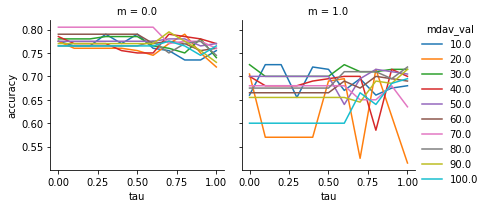

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.FacetGrid(clean_melt_df[clean_melt_df.mdav_ver == 'k'], col='m', hue='mdav_val',)
g = g.map(plt.plot, 'tau', 'accuracy').add_legend()

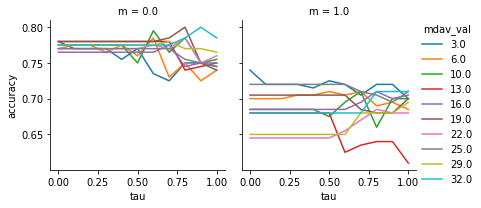

In [ ]:
g = sns.FacetGrid(clean_melt_df[clean_melt_df.mdav_ver == 'u'], col='m', hue='mdav_val',)
g = g.map(plt.plot, 'tau', 'accuracy').add_legend()

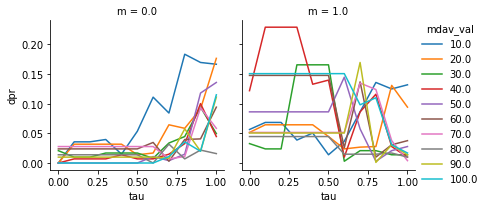

In [ ]:
g = sns.FacetGrid(clean_melt_df[clean_melt_df.mdav_ver == 'k'], col='m', hue='mdav_val',)
g = g.map(plt.plot, 'tau', 'dpr').add_legend()

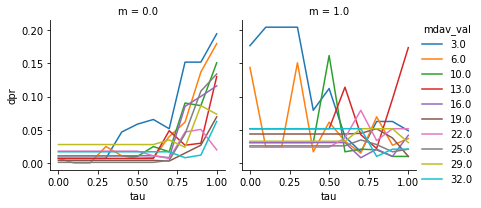

In [ ]:
g = sns.FacetGrid(clean_melt_df[clean_melt_df.mdav_ver == 'u'], col='m', hue='mdav_val',)
g = g.map(plt.plot, 'tau', 'dpr').add_legend()

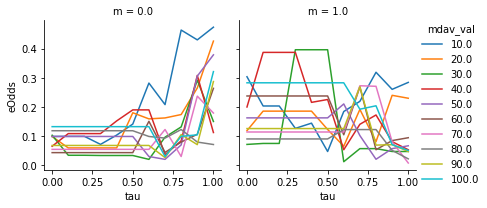

In [ ]:
g = sns.FacetGrid(clean_melt_df[clean_melt_df.mdav_ver == 'k'], col='m', hue='mdav_val',)
g = g.map(plt.plot, 'tau', 'eOdds').add_legend()

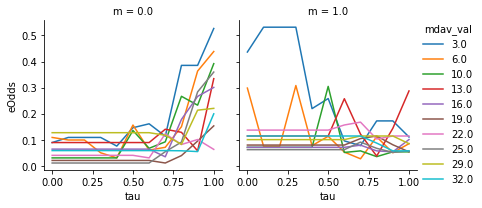

In [ ]:
g = sns.FacetGrid(clean_melt_df[clean_melt_df.mdav_ver == 'u'], col='m', hue='mdav_val',)
g = g.map(plt.plot, 'tau', 'eOdds').add_legend()

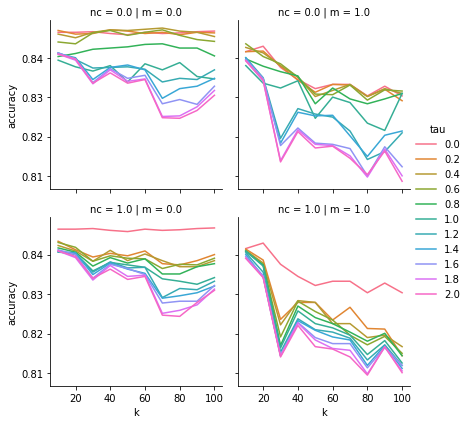

In [ ]:
g = sns.FacetGrid(met_df[(met_df.lf == 1) & (met_df.u == 0)], row='nc', col='m', hue='tau')
g = g.map(plt.plot, 'k', 'accuracy').add_legend()

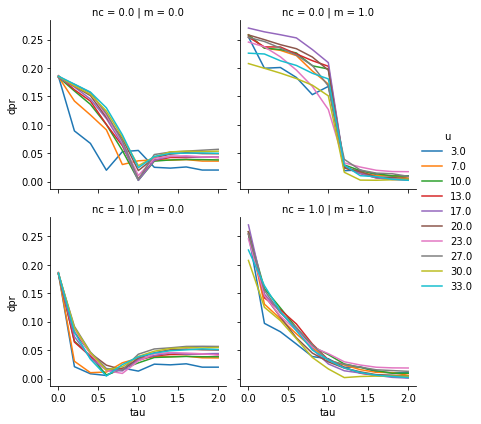

In [ ]:
g = sns.FacetGrid(met_df[(met_df.lf == 1) & (met_df.k == 0)], row='nc', col='m', hue='u')
g = g.map(plt.plot, 'tau', 'dpr').add_legend()

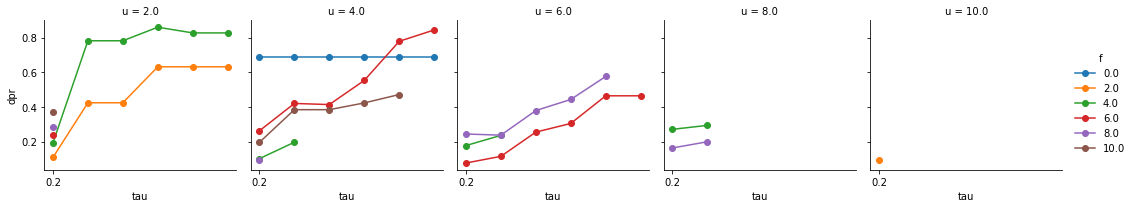

In [ ]:
g = sns.FacetGrid(met_df[met_df.accuracy >= 0.8], col='u', hue='f')
g = g.map(plt.plot, 'tau', 'dpr', marker='o').add_legend()

k-Anonymity experiment with $\tau = 0$

In [ ]:
mlist = []
pdict = {}

for i in trange(1, 11):
    value = str(i)
    name = 't0k' + value + 'u3f7'
    r = makeMetricsDF(name)
    m = r['metrics']
    m['k'] = value
    mlist.append(m)
    pdict[name] = r['preds']

preds_df = pd.read_csv('../Datasets/OHA_' + toPred + '_preds.csv')
for k in pdict.keys():
    preds_df[k] = pdict[k]
preds_df.to_csv('../Datasets/OHA_' + toPred + '_preds.csv', index=False)

met_df = pd.concat(mlist).reset_index(drop=True)
met_df = met_df[['k'] + [col for col in met_df.columns if col != 'k']]
met_df.to_csv('../Datasets/k-Anonymity_Experiment_t0_OHA_' + toPred + '.csv', index=False)
met_df

k  accuracy        f1  precision    recall       auc       dpr       eor  \
0   1  0.832425  0.594444   0.711996  0.510207  0.722391  0.012170  0.044328   
1   2  0.828816  0.588235   0.698618  0.507974  0.719252  0.012440  0.048117   
2   3  0.828931  0.590140   0.697088  0.511643  0.720580  0.032899  0.098172   
3   4  0.826705  0.583041   0.692713  0.503349  0.716282  0.015136  0.052194   
4   5  0.827549  0.581984   0.698615  0.498724  0.715258  0.014952  0.054516   
5   6  0.823787  0.568690   0.692132  0.482616  0.707280  0.010646  0.037444   
6   7  0.823288  0.576891   0.680842  0.500478  0.713051  0.012747  0.045197   
7   8  0.823748  0.587548   0.672701  0.521531  0.720544  0.016703  0.057374   
8   9  0.822136  0.536190   0.720086  0.427113  0.687239  0.019125  0.065911   
9  10  0.820485  0.534170   0.711518  0.427592  0.686316  0.012363  0.042299   

      eOdds  
0  0.023378  
1  0.024630  
2  0.059925  
3  0.028908  
4  0.029007  
5  0.020475  
6  0.024737  
7  0.032154  
8  0.035981  
9  0.023321

k-Anonymity experiment with $\tau = 1$

In [ ]:
mlist = []
pdict = {}

for i in trange(1, 11):
    value = str(i)
    name = 't1k' + value + 'u3f7'
    r = makeMetricsDF(name)
    m = r['metrics']
    m['k'] = value
    mlist.append(m)
    pdict[name] = r['preds']

preds_df = pd.read_csv('../Datasets/OHA_' + toPred + '_preds.csv')
for k in pdict.keys():
    preds_df[k] = pdict[k]
preds_df.to_csv('../Datasets/OHA_' + toPred + '_preds.csv', index=False)

met_df = pd.concat(mlist).reset_index(drop=True)
met_df = met_df[['k'] + [col for col in met_df.columns if col != 'k']]
met_df.to_csv('../Datasets/k-Anonymity_Experiment_OHA_' + toPred + '.csv', index=False)
met_df

k  accuracy        f1  precision    recall       auc       dpr       eor  \
0   1  0.826321  0.623878   0.651615  0.598405  0.748490  0.535019  0.899421   
1   2  0.829814  0.616953   0.673204  0.569378  0.740878  0.368749  0.764593   
2   3  0.824363  0.615385   0.650667  0.583732  0.742190  0.477805  0.869929   
3   4  0.830428  0.614741   0.678345  0.562041  0.738777  0.294498  0.700346   
4   5  0.829853  0.608826   0.681621  0.550080  0.734313  0.270305  0.595450   
5   6  0.824555  0.596788   0.667852  0.539394  0.727175  0.343968  0.718736   
6   7  0.824785  0.597956   0.667847  0.541308  0.727980  0.315201  0.667781   
7   8  0.823441  0.603364   0.656901  0.557895  0.732760  0.322863  0.639657   
8   9  0.824439  0.567483   0.697188  0.478469  0.706294  0.418095  0.888388   
9  10  0.823557  0.548881   0.713629  0.445933  0.694602  0.286408  0.653781   

      eOdds  
0  0.862832  
1  0.613121  
2  0.770751  
3  0.503360  
4  0.454966  
5  0.569975  
6  0.523082  
7  0.525151  
8  0.711328  
9  0.493958

In [ ]:
mlist = []
pdict = {}

for i in trange(11):
    u_value = str(i)
    f_value = str(10 - i)
    name = 't1k1u' + u_value + 'f' + f_value
    r = makeMetricsDF(name)
    m = r['metrics']
    m['u'] = u_value
    m['f'] = f_value
    mlist.append(m)
    pdict[name] = r['preds']

preds_df = pd.read_csv('../Datasets/OHA_' + toPred + '_preds.csv')
for k in pdict.keys():
    preds_df[k] = pdict[k]
preds_df.to_csv('../Datasets/OHA_' + toPred + '_preds.csv', index=False)

met_df = pd.concat(mlist).reset_index(drop=True)
cols_to_move = ['u', 'f']
met_df = met_df[cols_to_move + [col for col in met_df.columns if col not in cols_to_move]]
met_df.to_csv('../Datasets/Fairlets_Experiment_OHA_' + toPred + '.csv', index=False)
met_df

u   f  accuracy        f1  precision    recall       auc       dpr  \
0    0  10  0.834498  0.611166   0.703342  0.540351  0.734049  0.219195   
1    1   9  0.696522  0.503735   0.415364  0.639872  0.677177  2.485831   
2    2   8  0.815379  0.609501   0.620844  0.598565  0.741339  0.805135   
3    3   7  0.826321  0.623878   0.651615  0.598405  0.748490  0.535019   
4    4   6  0.831081  0.632414   0.664035  0.603668  0.753422  0.416424   
5    5   5  0.828471  0.607933   0.675771  0.552472  0.734220  0.168536   
6    6   4  0.830045  0.638406   0.654278  0.623285  0.759438  0.465608   
7    7   3  0.813920  0.636956   0.600480  0.678150  0.767556  0.491243   
8    8   2  0.800752  0.635380   0.567805  0.721212  0.773590  0.406503   
9    9   1  0.758600  0.609052   0.499083  0.781180  0.766311  0.550682   
10  10   0  0.813652  0.434398   0.806228  0.297289  0.637319  0.623881   

         eor     eOdds  
0   0.483423  0.373094  
1   1.665104  3.661316  
2   1.231961  1.282670  
3   0.899421  0.862832  
4   0.834966  0.685747  
5   0.322969  0.273703  
6   1.018772  0.775449  
7   0.977078  0.776690  
8   0.880890  0.650133  
9   0.961978  0.791163  
10  1.508432  1.161068

In [ ]:
income = pd.read_csv('../Datasets/income_onehot.csv')
compas = pd.read_csv('../Datasets/compas_onehot.csv')
german = pd.read_csv('../Datasets/german_onehot.csv')

In [ ]:
income.groupby('sex').label.value_counts()

sex  label
0    0         9592
     1         1179
1    0        15128
     1         6662
Name: label, dtype: int64

In [ ]:
def max_dpr(df=income, acc=1):
    
    f_plus = df[df.sex == 1].label.value_counts()[1]
    f_minus = df[df.sex == 1].label.value_counts()[0]
    f = f_plus + f_minus
    
    u_plus = df[df.sex == 0].label.value_counts()[1]
    u_minus = df[df.sex == 0].label.value_counts()[0]
    u = u_plus + u_minus
    
    thres = round((1 - acc) * df.shape[0], 0)
    i = 2
    
    while (thres > 0) & (i > 0):
        if (f >= u) & (u_minus > 0):
            to_relabel = min(u_minus, thres)
            u_plus = u_plus + to_relabel
            u_minus = u_minus - to_relabel
            thres = thres - to_relabel
        elif (f_plus > 0):
            to_relabel = min(f_plus, thres)
            f_plus = f_plus - to_relabel
            f_minus = f_minus + to_relabel
            thres = thres - to_relabel
        i -= 1
    dpr = (u_plus / u) / (f_plus / f)
    return dpr

In [ ]:
max_dpr(df=income, acc=0.93)

1.0500780125514098

In [ ]:
dpr_per_acc = [max_dpr(df=income, acc=1-0.002*i) for i in range(100)]
acc = [1-0.002*i for i in range(100)]


In [ ]:
met_df = met_df[met_df.dpr < 100]

In [ ]:
met_df['sum'] = met_df.u + met_df.f

/home/vladox/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


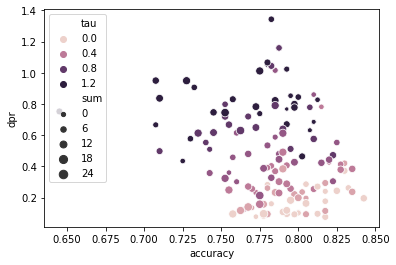

In [ ]:
plot_df = pd.DataFrame({'accuracy': acc, 'dpr': dpr_per_acc})
# plt.plot(plot_df.accuracy, plot_df.dpr)
sns.scatterplot(data=met_df, x='accuracy', y='dpr', hue='tau', size='sum')

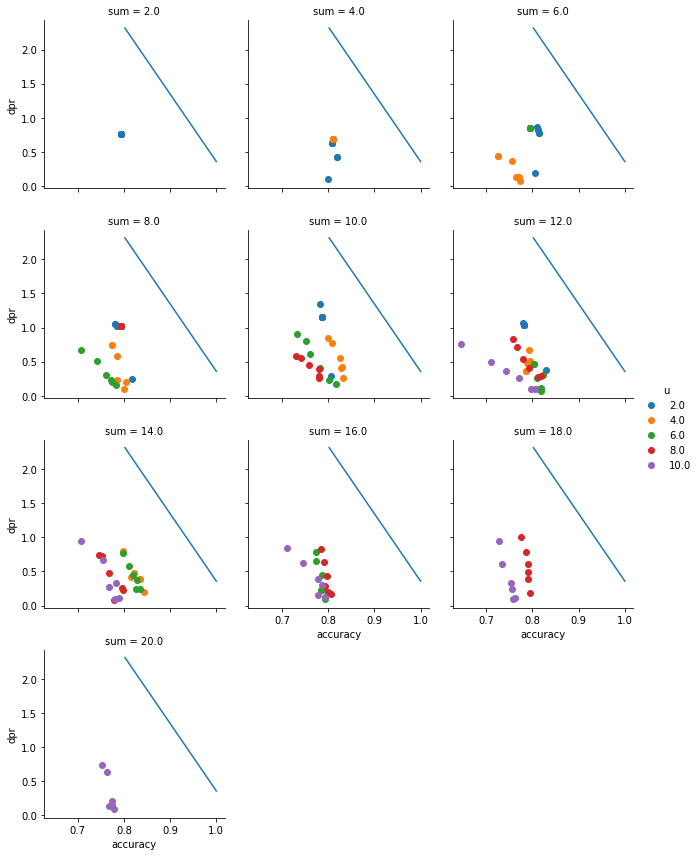

In [ ]:
g = sns.FacetGrid(met_df, col='sum', col_wrap=3, hue='u')
g = g.map(plt.scatter, 'accuracy', 'dpr', marker='o',).add_legend()

axes = g.fig.axes
for ax in axes:
    ax.plot(plot_df.accuracy, plot_df.dpr)

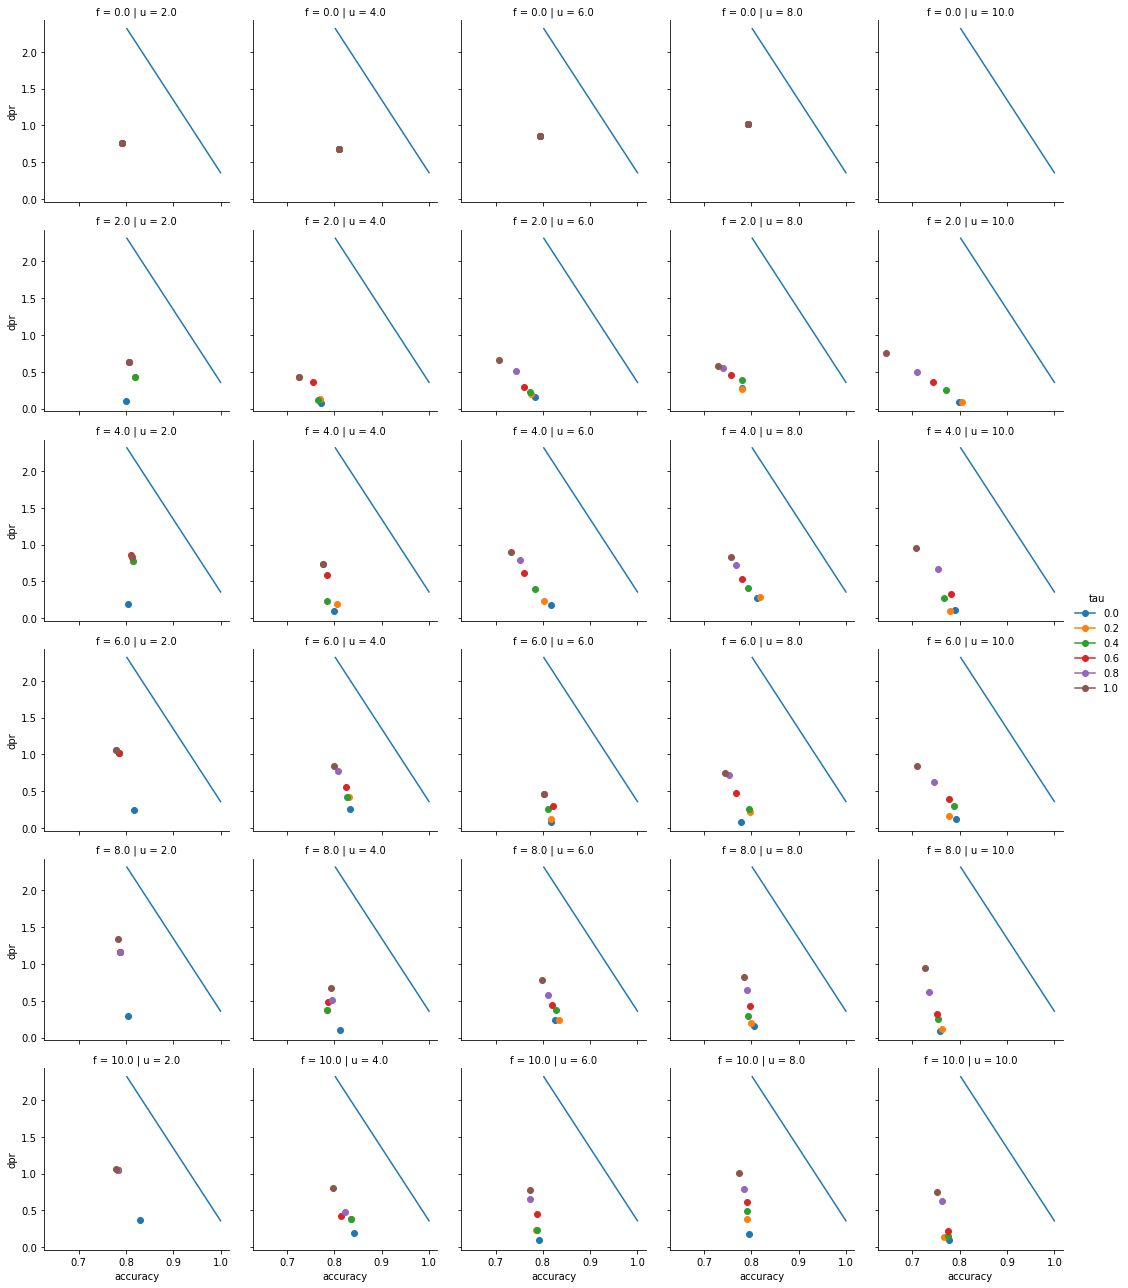

In [ ]:
g = sns.FacetGrid(met_df, row='f', col='u', hue='tau')
g = g.map(plt.plot, 'accuracy', 'dpr', marker='o').add_legend()

axes = g.fig.axes
for ax in axes:
    ax.plot(plot_df.accuracy, plot_df.dpr)

In [ ]:
dpr_per_acc

[0.3580225496813511,
 0.3680435370770123,
 0.37776085818795657,
 0.3877818455836178,
 0.397499166694562,
 0.4075201540902232,
 0.41723747520116744,
 0.42725846259682865,
 0.43697578370777285,
 0.4469967711034341,
 0.4570177584990953,
 0.4667350796100395,
 0.4767560670057008,
 0.486473388116645,
 0.49649437551230624,
 0.5062116966232505,
 0.5162326840189116,
 0.5262536714145729,
 0.5359709925255172,
 0.5459919799211783,
 0.5557093010321226,
 0.5657302884277838,
 0.575447609538728,
 0.5854685969343892,
 0.5951859180453335,
 0.6052069054409946,
 0.6152278928366559,
 0.6249452139476002,
 0.6349662013432613,
 0.6446835224542056,
 0.6547045098498668,
 0.664421830960811,
 0.6744428183564722,
 0.6844638057521335,
 0.6941811268630776,
 0.7042021142587389,
 0.7139194353696832,
 0.7239404227653443,
 0.7336577438762887,
 0.7436787312719498,
 0.753396052382894,
 0.7634170397785552,
 0.7734380271742165,
 0.7831553482851606,
 0.7931763356808219,
 0.8028936567917662,
 0.8129146441874274,
 0.8226319652